### This file tests the accuracy of shock estimation under different DGPs
* Use different sationary ARMA models to test accuracy of impulse reponses
* Generate a random set each time with different lag structure
* Should give a solid idea of the bias variance tradeoff with LP 
* Should also indicate how this tradeoff evolves as T -> infinity
* Possible future additions: Compare fit under different loss functions

In [2]:
#Import statement
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.ar_model import *
import seaborn as sns 
from lppy import locproj

order: 3 and 4
failed this loop
order: 3 and 3
failed this loop
order: 3 and 5
order: 3 and 2
failed this loop
order: 3 and 4
failed this loop


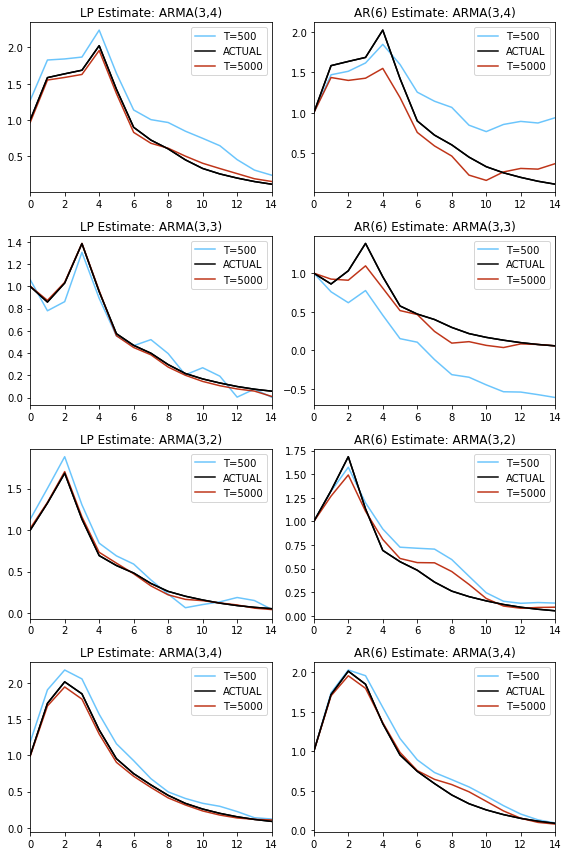

In [26]:
#Display subplots for each fitted model 
fig, axs = plt.subplots(4,2, figsize = (8, 12))

#Plot index variable
i = 0

#AR Lag order
AR_lag_l = 6

while i < 4:
    # try:

        #Generate vectors for the ARMA process parameters
        rng = np.random.default_rng()
        
        p=3
        arparams = np.array([.75, -.25, .2])
        
        q = rng.integers(low=2, high=7, size=1)[0]
        maparams = np.random.rand(q,1)
        print(f"order: {p} and {q}")
        
        ar = np.r_[1, -arparams] # add zero-lag and negate
        ma = np.r_[1, maparams[:,0]] # add zero-lag

        param_vec = np.r_[ar,ma]
        arma_process = sm.tsa.ArmaProcess(ar, ma)
        if arma_process.isstationary ==False or arma_process.isinvertible == False:
                continue
        
        #Generate ARMA Sample    
        y = arma_process.generate_sample(10000)
        model = sm.tsa.ARIMA(y,order= (p, 0, q), trend='n').fit()
        #Test that the fitted is actually the true model
        # print(model.params)
        # print(param_vec)
        
        #Back out the structural shock
        residual = y - model.fittedvalues

        #Vector of sample size and color, loop over this for each plot 
        ss_vec = {500:"#5bbffc", 5000:"#b81f00"}
        
        for ss in ss_vec:
            
            armodel = AutoReg(y[0:ss],lags=AR_lag_l).fit()
 
            ar_fcast = np.zeros(15)
            last_vals = np.zeros(AR_lag_l)
            last_vals[0] = 1
            ar_fcast[0] =1
            for tstep in range(1,15):
                resp = sum(armodel.params * [1, *last_vals])
                ar_fcast[tstep] = resp
                last_vals[1:AR_lag_l] = last_vals[0:(AR_lag_l-1)] 
                last_vals[0] = resp
                
            
            #Compute LP 
            irf = locproj(residual[0:ss],y[0:ss],0,15,99)
            
            #Define plots here 
            axs[i,0].plot(irf.resp,color = ss_vec[ss] ,alpha = .9,label = f"T={ss}")
            axs[i,0].legend()
            axs[i,0].set_title(f"LP Estimate: ARMA({p},{q})")
            axs[i,0].plot(arma_process.impulse_response(15),color='black',label='ACTUAL')
            axs[i,0].set_xlim([0, 14])
            
            axs[i,1].plot(ar_fcast,color = ss_vec[ss],alpha = .9,label = f"T={ss}")
            axs[i,1].legend()
            axs[i,1].set_title(f"AR({AR_lag_l}) Estimate: ARMA({p},{q})")
            axs[i,1].plot(arma_process.impulse_response(15),color='black',label='ACTUAL')
            axs[i,1].set_xlim([0, 14])
            
        i +=1
    # except:
        print("failed this loop")


plt.tight_layout()
